In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [2]:
def read_tsp_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    location_data = []
    for line in lines:
        parts = line.split()
        if len(parts) == 3 and parts[0].isdigit():
            city_number = int(parts[0])
            longitude = float(parts[1])
            latitude = float(parts[2])
            location_data.append([city_number, longitude, latitude])
    return np.array(location_data)

In [3]:
def adjusting(another_df):
    data = []            
    with open(another_df, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("TOUR_SECTION"):
                break
        
        for line in file:
            if line.startswith("-1"):
                break
            location_index = int(line)
            data.append(location_index)
    data = np.array(data)
    data = data.reshape(data.shape[0],1)
    return data

In [4]:
file_path1 = 'berlin52.tsp'
location_data = read_tsp_file(file_path1)

file_path2 = 'berlin52.opt.tour'
optimal_tour = adjusting(file_path2)

In [5]:
def bestDistance(x1, x2, y1, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [6]:
def optimal_norm(optimal_tour, location_data):
    optDistance = 0
    for i in range(len(optimal_tour)):
        current_city_index = optimal_tour[i] - 1
        next_city_index = optimal_tour[(i + 1) % len(optimal_tour)] - 1
    
        current_city = location_data[current_city_index]
        next_city = location_data[next_city_index]
    
        distance_to_next_optimal = bestDistance(current_city[:, 1].item(), next_city[:, 1].item(), current_city[:, 2].item(), next_city[:, 2].item())
        optDistance += distance_to_next_optimal
    return optDistance

In [7]:
def distance(city1, city2):
    return np.sqrt((city1[1] - city2[1])**2 + (city1[2] - city2[2])**2)

In [8]:
def total_distance(tour, location_data):
    dist = 0
    for i in range(len(tour)):
        city_idx = tour[i] - 1
        next_city_idx = tour[(i + 1) % len(tour)] - 1
        dist += distance(location_data[city_idx], location_data[next_city_idx])
    return dist

In [9]:
def initialize_bats(population_size, num_cities):
    return np.array([np.random.permutation(num_cities) for _ in range(population_size)])

In [10]:
def ensure_tsp_criteria(route, num_cities):
    valid_cities = np.arange(1, num_cities + 1)
    unique_cities, city_counts = np.unique(route, return_counts=True)
    
    for i in range(len(route)):
        if route[i] < 1 or route[i] > num_cities or city_counts[np.where(unique_cities == route[i])] > 1:
            while True:
                new_value = np.random.choice(valid_cities)
                if new_value != route[i] and new_value not in unique_cities:
                    route[i] = new_value
                    unique_cities, city_counts = np.unique(route, return_counts=True)
                    break
    
    return route

In [437]:
def bat_algorithm_tsp(location_data, population_size, max_iterations, bbd, r0=0.9, alpha=0.9, csi=0.9):
    num_cities = len(location_data)
    bats = initialize_bats(population_size, num_cities)
    pulse_rates = np.ones(population_size) * r0
    loudness = np.ones(population_size)
    fmin = 0
    fmax = 0.02
    velocity = np.zeros((population_size, num_cities))
    V = [0.5 for _ in range(population_size)]

    best_solution = bats.copy()
    best_distance = np.array([total_distance(best_solution[i], location_data) for i in range(population_size)])

    for x in range(max_iterations):
        for i in range(population_size):
            new_solution = best_solution[i].copy()
            F = fmin + (fmax - fmin) * np.random.random()
            velocity[i] += new_solution - (best_solution[np.argmin(best_distance)] * F)
            new_solution += velocity[i].astype(int)
            
            for _ in range(num_cities):
                if np.random.random() > pulse_rates[i]:
                    j = np.random.randint(population_size)
                    diff = best_solution[j] - new_solution
                    new_solution = diff * (np.sum(V) / population_size)
                    new_solution = new_solution.astype(int)
                new_solution = ensure_tsp_criteria(new_solution, num_cities)
                if total_distance(new_solution, location_data) < total_distance(bats[i], location_data) and np.random.random() < loudness[i]:
                    bats[i] = new_solution
                    pulse_rates[i] *= (1 - np.exp(-csi * max_iterations))
                    loudness[i] *= alpha
            
            new_solution_distance = total_distance(new_solution, location_data)
            if new_solution_distance < best_distance[i]:
                best_solution[i] = new_solution.copy()
                best_distance[i] = new_solution_distance
         
        min_distance_index = np.argmin(best_distance)
        my_best_bat_distance = best_distance[min_distance_index]
        print("For Population {}, Iteration {}'s best bat distance:".format(population_size, x+1), round(my_best_bat_distance, 2))
    
    bbd.append(my_best_bat_distance)
    return bbd

In [438]:
def relativeError(opt, best):
    return abs((opt-best))/opt * 100

In [439]:
best_bat_distance = []
optimal_distance = optimal_norm(optimal_tour, location_data)
population_size = [50]#, 100, 200, 500
max_iterations = 1000

for b in range(len(population_size)):
    best_bat_distance = bat_algorithm_tsp(location_data, population_size[b], max_iterations, best_bat_distance)

print()
print("Optimal Distance =", round(optimal_distance, 2))

error = []
for re in range(len(best_bat_distance)):
    print("For Population {}, Bat's Best Distance = {}".format(population_size[re], round(best_bat_distance[re], 2)))
    myError = round(relativeError(optimal_distance, best_bat_distance[re]), 2)
    error.append(myError)
    print("For Population {}, Relative Percentage Error = {}%".format(population_size[re], error[re]))

For Population 50, Iteration 1's best bat distance: 25750.36
For Population 50, Iteration 2's best bat distance: 25750.36
For Population 50, Iteration 3's best bat distance: 25742.52
For Population 50, Iteration 4's best bat distance: 25441.96
For Population 50, Iteration 5's best bat distance: 25441.96
For Population 50, Iteration 6's best bat distance: 25441.96
For Population 50, Iteration 7's best bat distance: 25441.96
For Population 50, Iteration 8's best bat distance: 25441.96
For Population 50, Iteration 9's best bat distance: 25441.96
For Population 50, Iteration 10's best bat distance: 24643.83
For Population 50, Iteration 11's best bat distance: 24643.83
For Population 50, Iteration 12's best bat distance: 24643.83
For Population 50, Iteration 13's best bat distance: 24643.83
For Population 50, Iteration 14's best bat distance: 24643.83
For Population 50, Iteration 15's best bat distance: 24643.83
For Population 50, Iteration 16's best bat distance: 24643.83
For Population 50

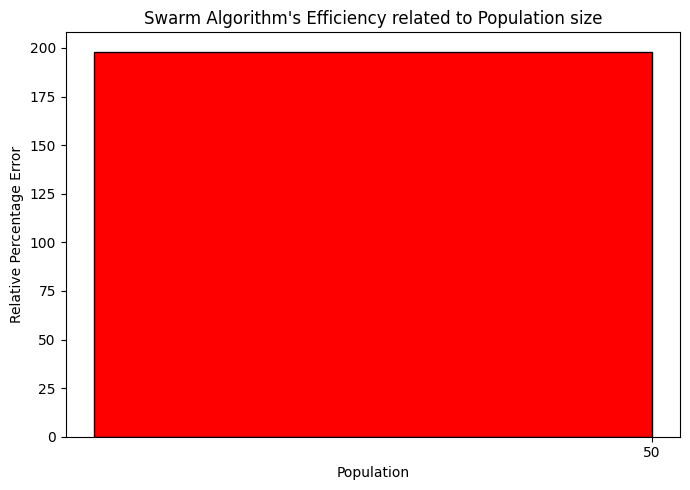

In [440]:
bar_colors = ['red']#, 'green', 'blue', 'purple'
fig, ax = plt.subplots(figsize=(7, 5))
bar_width = 0.4  

bar_spacing = 0.2 
x_positions = [i * (bar_width + bar_spacing) for i in range(len(population_size))]
ax.bar(x_positions, error, width = bar_width, color = bar_colors, edgecolor='black')
ax.set_xticks([pos + bar_width / 2 for pos in x_positions])
ax.set_xticklabels(population_size)
ax.set_xlabel('Population')
ax.set_ylabel('Relative Percentage Error')
ax.set_title("Swarm Algorithm's Efficiency related to Population size")
plt.tight_layout()  
plt.show()